In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import yfinance as yf
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import metrics
import math
import statistics
pd.set_option('display.max_rows', 10000)
plt.style.use('ggplot')
%matplotlib inline

In [2]:
# import the data
# NOTE: may have to get rid of engine parameter for it to run
stock_data = pd.read_excel('csds442_data2.xlsx', engine='openpyxl')
stock_data.columns =  ['Symbol','Treated', 'CompanyName', 'MarketCap','ShortPercent', 'Sector', 'TrailingEPS', 'Nov2020', 'Jan2021', 'BeforeTreatment', 'AfterTreatment']

# derive a couple new columns from the data
stock_data['PriorThreeMonths'] = (stock_data['Jan2021'] - stock_data['Nov2020'])/stock_data['Nov2020']
stock_data['TreatmentChange'] = 100*((stock_data['AfterTreatment'] - stock_data['BeforeTreatment'])/stock_data['BeforeTreatment'])

# add mention column that specifies the number of mentions the stock has based on SwaggyStocks data
stock_data['Mentions'] = np.nan
mention_set = pd.read_csv('swaggy_data.csv')
for i in range(len(stock_data)):
    if stock_data['Symbol'].iloc[i] in list(mention_set['tk']):
        stock_data['Mentions'].iloc[i] = int(mention_set[mention_set['tk'] == stock_data['Symbol'].iloc[i]]['ment'].iloc[0])

# take the log of market cap
stock_data['lg'] = 0
for i in range(len(stock_data)):
    stock_data['lg'].iloc[i] = math.log(stock_data['MarketCap'].iloc[i])
    
# create new columns for each of the sectors that stocks could belong to, where the value is 1 if
# the stock is in that sector and 0 otherwise
dummies = pd.get_dummies(stock_data['Sector'], drop_first=True)
stock_data = pd.concat([stock_data, dummies], axis=1)

# run logitstic regression on the data set
logreg = LogisticRegression()
X = stock_data[['lg', 'ShortPercent', 'PriorThreeMonths', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities']]
X = X.fillna(X.median())
y = stock_data[['Treated']]
a = logreg.fit(X, y)

stock_data['PropensityForTreatment']=a.predict_proba(X)[:,1]

prob_no_treatment = stock_data['Treated'].value_counts()[0] / len(stock_data)
prob_treatment = stock_data['Treated'].value_counts()[1] / len(stock_data)

# get weights based on propensity scoring
stock_data['Weight'] = np.nan
for i in range(len(stock_data)):
    if stock_data['Treated'].iloc[i] == 1:
        stock_data['Weight'].iloc[i] = 1 / stock_data['PropensityForTreatment'].iloc[i]
    else:
        stock_data['Weight'].iloc[i] = 1 / (1 - stock_data['PropensityForTreatment'].iloc[i])

/home/ctt0/.local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/home/ctt0/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/ctt0/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solve

In [3]:
#Help find the nearest propensity function
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]
    
# propensity score matching
to_match = stock_data[stock_data['Treated']==1].sort_values('PropensityForTreatment', ascending=False)
controls = stock_data[stock_data['Treated']==0].sort_values('PropensityForTreatment')
matches = controls.iloc[[-1]]
controls = controls.drop(controls.index[-1])
for i in range(1,len(to_match)):
    current_score = to_match['PropensityForTreatment'].iloc[i]
    upper_j = 0
    lower_j = 0
    for j in range(len(controls)):
        if controls['PropensityForTreatment'].iloc[j] > current_score:
            upper_j = j
            lower_j = j-1
            break
    if upper_j == 0:
        matches = matches.append(controls.iloc[[-1]])
        controls = controls.drop(controls.index[-1])
    else:
        if abs(controls['PropensityForTreatment'].iloc[upper_j] - current_score) > abs(controls['PropensityForTreatment'].iloc[lower_j] - current_score):
            matches =matches.append(controls.iloc[[lower_j]])
            controls = controls.drop(controls.index[lower_j])
        else:
            matches =matches.append(controls.iloc[[upper_j]])
            controls = controls.drop(controls.index[upper_j])
            
frames = [to_match, matches]
stock_data = pd.concat(frames)

In [4]:
# run linear regression on the treated values
model = LinearRegression()
X_treatment =np.array(list( stock_data['Treated'])).reshape(-1, 1)
y_result = np.array(list(stock_data['TreatmentChange'])).reshape(-1, 1)
model.fit(X_treatment, y_result)

beta_0 = model.intercept_[0]
beta_1 = model.coef_[0][0]

result_matching = 'Beta_0 = ' + str(round(beta_0,3)) + ' and Beta_1 = ' + str(round(beta_1,3))

print(result_matching)

Beta_0 = 2.794 and Beta_1 = 5.354


Text(0, 0.5, 'Treated Subject Propensity Score')

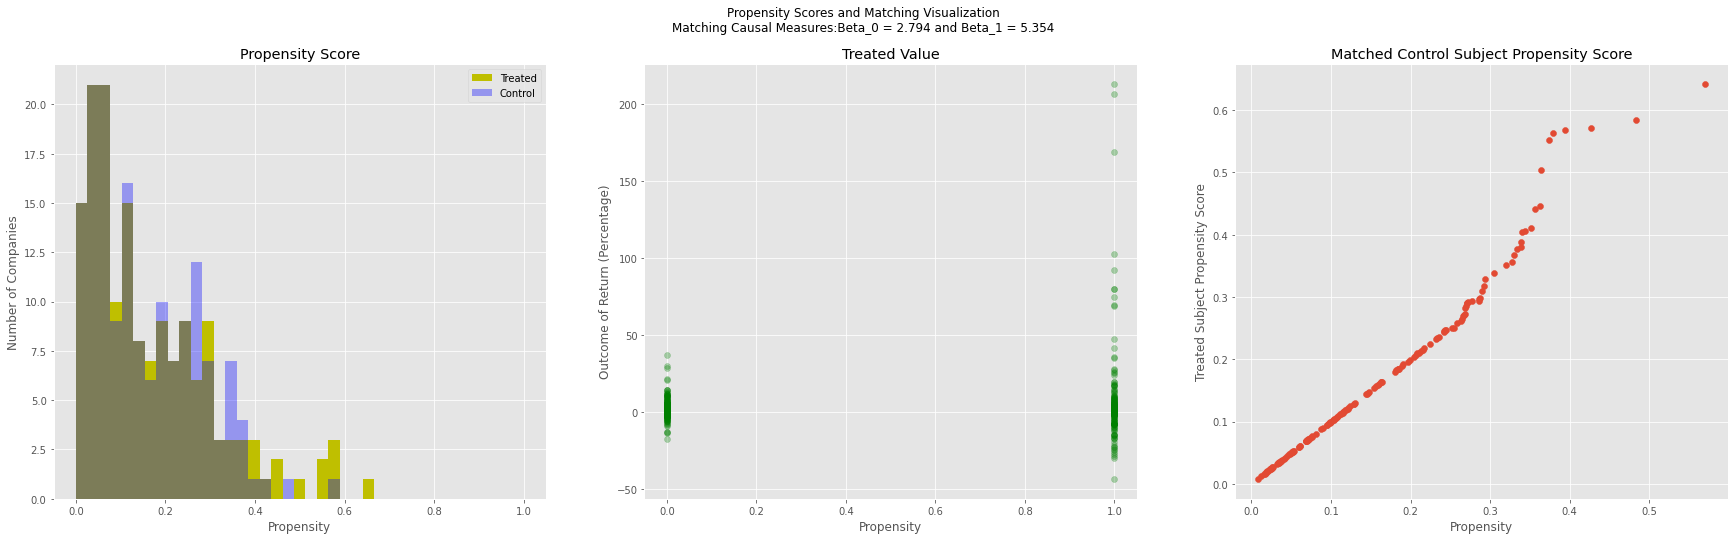

In [5]:
# plot the propensity scores for the treated and untreated
plt.figure()
fig = plt.gcf()
fig.set_size_inches(30, 8)

fig.suptitle('Propensity Scores and Matching Visualization\nMatching Causal Measures:' + result_matching)

plt.subplot(1,3,1)
prop_treatment = list(stock_data[stock_data['Treated'] == 1]['PropensityForTreatment'])
prop_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['PropensityForTreatment'])
y1 = prop_treatment
y2 = prop_no_treatment

bins = np.linspace(0, 1, 40)

plt.hist(y1, bins, label = 'Treated',color = 'y')
plt.hist(y2, bins, alpha = .35, label = 'Control',color =  'b')
plt.legend()
plt.title('Propensity Score')
plt.xlabel('Propensity')
plt.ylabel('Number of Companies')

# plot the returns for the treated and untreated

plt.subplot(1,3,2)
plt.scatter(stock_data['Treated'], stock_data['TreatmentChange'], alpha =.3, color = 'g')
plt.title('Treated Value')
plt.xlabel('Propensity')
plt.ylabel('Outcome of Return (Percentage)')

# plot the matched control subject propensity scores

plt.subplot(1,3,3)
plt.scatter(matches['PropensityForTreatment'], to_match['PropensityForTreatment'])
plt.title('Matched Control Subject Propensity Score')
plt.xlabel('Propensity')
plt.ylabel('Treated Subject Propensity Score')

In [6]:
# function to sample an input number of times to get multiple causal effect measure values
def bootstrap_standard(dataframe, run_count):
    
    # sample should be same size as input data set
    sample_size = dataframe.shape[0]
    alpha_0_list = []
    alpha_1_list = []
    for i in range(run_count):
        
        # draw new sample with replacement
        sample = dataframe.sample(sample_size, replace=True)
        
        model = LinearRegression()
        
        # run linear regression on sample, where we use weights if parameter ipw is true and do not otherwise
        X_treatment =np.array(list(sample['Treated'])).reshape(-1, 1)
        y_result = np.array(list(sample['TreatmentChange'])).reshape(-1, 1)
        model.fit(X_treatment, y_result)

        alpha_0_list.append(model.intercept_[0])
        alpha_1_list.append(model.coef_[0][0])
        
    return(alpha_0_list, alpha_1_list)

(array([ 10.,  70., 127., 216., 228., 173., 109.,  44.,  17.,   6.]),
 array([-1.7228028 , -0.12840748,  1.46598783,  3.06038315,  4.65477846,
         6.24917378,  7.84356909,  9.43796441, 11.03235972, 12.62675504,
        14.22115035]),
 <BarContainer object of 10 artists>)

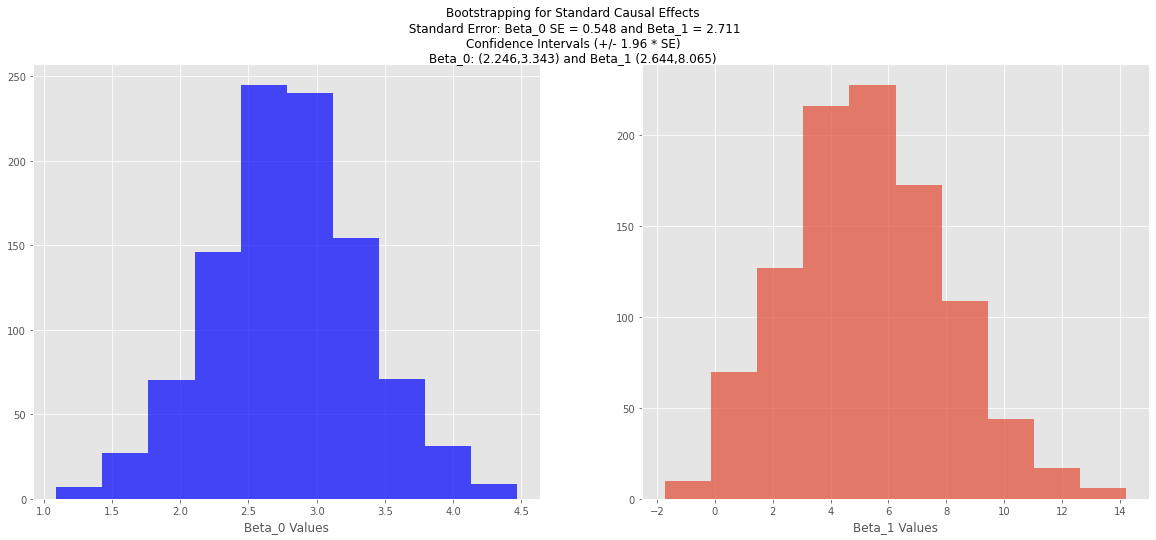

In [7]:
# generate 1000 samples using bootstrapping
alpha_0, alpha_1 = bootstrap_standard(stock_data,1000)
b0_se = statistics.stdev(alpha_0)
b1_se = statistics.stdev(alpha_1)
se_orig = 'Beta_0 SE = ' + str(round(b0_se,3)) + ' and Beta_1 = ' + str(round(b1_se,3))
confidence = 'Beta_0: (' + str(round(beta_0 - b0_se,3)) + ',' + str(round(beta_0 + b0_se,3)) + ') and Beta_1 (' + str(round(beta_1 - b1_se,3)) + ',' + str(round(beta_1 + b1_se,3)) +')'


# plot the beta_0 and beta_1 values for all samples
plt.figure()
fig = plt.gcf()
fig.set_size_inches(20, 8)

fig.suptitle('Bootstrapping for Standard Causal Effects\n Standard Error: ' + se_orig + '\nConfidence Intervals (+/- 1.96 * SE)\n'+ confidence)

plt.subplot(1,2,1)
plt.xlabel('Beta_0 Values')
plt.hist(alpha_0, alpha= .7, color = 'b')

plt.subplot(1,2,2)
plt.xlabel('Beta_1 Values')
plt.hist(alpha_1, alpha = .7)